# Libraries

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
%matplotlib inline

In [30]:
def visualize_images(input_images, num_cols, figure_name, cmap=None):
    "Shows input images by stacking them in num_cols columns"
    fig, axes = plt.subplots(
        (int)((len(input_images) + 1) / num_cols), num_cols, figsize=(24, 20))

    fig = plt.gcf()
    fig.canvas.manager.set_window_title(figure_name)

    print(figure_name)

    for ax, image in zip(axes.flat, input_images):
        if(cmap == "gray" or cmap == 'hot'):
            ax.imshow(image, cmap=cmap)
        elif(image.shape[2] == 1):
            ax.imshow(image[:, :, 0], cmap=cmap)
        else:
            ax.imshow(image, cmap=cmap)

    plt.show()


In [31]:
def convert_color(img, conv='RGB2YCrCb'):
    """
    Convert the image from one color space to the other
    """
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'Gray':
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)


# HOG features

In [32]:
from skimage.feature import hog


def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    """
    Return the hog features of the given input image
    Call with two outputs if vis==True"""
    # THE RETURN HOG FEATURES & HOG IMAGE 
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
     # THE RETURN HOG FEATURES ONLY
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=( cell_per_block, cell_per_block), transform_sqrt=True,
                       visualize=vis, feature_vector=feature_vec)
        return features


# Reading images

In [33]:
#Read cars and not-cars images

#Data folders
test_images_dir = './test_images/'

# images are divided up into vehicles and non-vehicles
test_images = []

images = glob.glob(test_images_dir + '*.jpg')

for image in images:
    test_images.append(mpimg.imread(image))


In [34]:
import pickle 
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
#print(dist_pickle)
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]

# Finding windows with cars

In [35]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, vis_bboxes=False):
    #print(img.shape)
    draw_img = np.copy(img)
    #cropping only needed part of picture (that includes cars)
    xstart = int(img.shape[1]/5)
    xstop = img.shape[1]
    img_tosearch = img[ystart:ystop, xstart:xstop, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1: #decrease picture size according to
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(
            ctrans_tosearch, (int(imshape[1]/scale), int(imshape[0]/scale)))  #resize(img,(width,height))
        
    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]
   
    # Define blocks and steps as above #(height,width,channels) 
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1 # (width //8)-2+1  = 127
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 # (height //8)-2+1 =15
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1 #7 blocks per window 

    # Instead of overlap, define how many cells to step
    # 2 means 25% of the 8 pixels ==> 75% overlap with the next window vertiaccly & horizontally
    cells_per_step = 2  
    
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell,
                            cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell,
                            cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell,
                            cell_per_block, feature_vec=False)
    rectangles = []

    #The find_cars only has to extract hog features once, for each of a small set of predetermined window sizes
    #  (defined by a scale argument), and then can be sub-sampled to get all of its overlaying windows.
    #  Each window is defined by a scaling factor that impacts the window size. The scale factor can be set on different 
    # regions of the image (e.g. small near the horizon, larger in the center).

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window,
                             xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window,
                             xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window,
                             xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack(
                (hog_feat1, hog_feat2, hog_feat3)).reshape(1, -1)
#             hog_features = np.hstack((hog_feat1))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            test_features = X_scaler.transform(hog_features)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1 or vis_bboxes == True:
                xbox_left = int(xleft*scale)
                ytop_draw = int(ytop*scale)
                win_draw = int(window*scale)
                rectangles.append(((xbox_left+xstart, ytop_draw+ystart),
                                  (xbox_left+win_draw+xstart, ytop_draw+win_draw+ystart))) #each rectangle is in form ((x1,y1),(x2,y2))
    return rectangles


# Detect all windows that includes cars

In [36]:
def get_rectangles(image, scales=[1, 1.5, 2, 2.5, 3],
                   ystarts=[400, 400, 450, 450, 460],
                   ystops=[528, 550, 620, 650, 700]):
    out_rectangles = []
    svc = pickle.load(open('svc_pickle.pkl', 'rb'))
    for scale, ystart, ystop in zip(scales, ystarts, ystops):
        rectangles = find_cars(image, ystart, ystop, scale,
                               svc, X_scaler, orient, pix_per_cell, cell_per_block)
        if len(rectangles) > 0:
            out_rectangles.append(rectangles)  
    out_rectangles = [item for sublist in out_rectangles for item in sublist]
    return out_rectangles


# Draw all boxes


In [37]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0, 255), np.random.randint(
                0, 255), np.random.randint(0, 255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick) #cv2.rectangle(image_to_draw_on, (x1, y1), (x2, y2), color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Visualizing windows with different scales

Windows with different scales


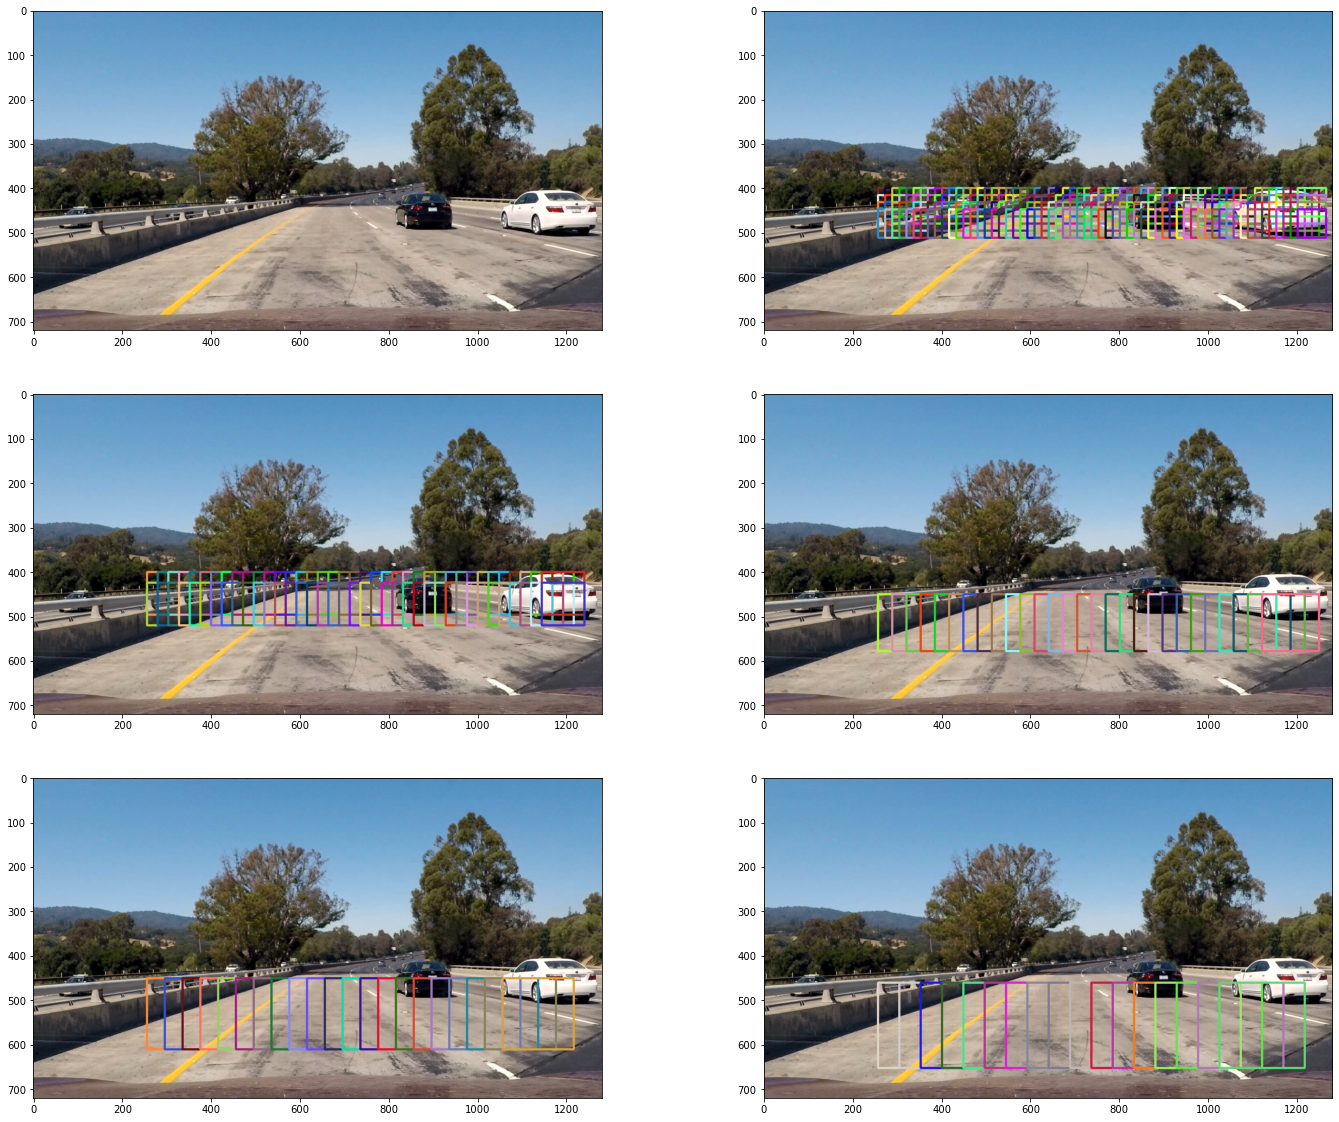

In [38]:
image = test_images[0]
scales=[1, 1.5, 2, 2.5, 3]
ystarts=[400, 400, 450, 450, 460]
ystops=[528, 550, 620, 650, 700]
out_rectangles = []
scale_images = []
imcopy = np.copy(image)
scale_images.append(imcopy)
#svc = pickle.load(open('svc_pickle.p', 'rb'))

for scale, ystart, ystop in zip(scales, ystarts, ystops):
    rectangles = find_cars(image, ystart, ystop, scale, svc, X_scaler,
                            orient, pix_per_cell, cell_per_block, vis_bboxes=True) #function is called 5 times for each image 
    if len(rectangles) > 0:
        out_rectangles.append(rectangles)
    out_rectangles = [item for sublist in out_rectangles for item in sublist]
    scale_image= draw_boxes(imcopy,out_rectangles,color='random',thick=3)
    scale_images.append(scale_image)
    out_rectangles=[]
visualize_images(scale_images,2,"Windows with different scales")

# Add heat to areas with most detections

In [39]:
def add_heat(heatmap, bbox_list):
    # bbox_list contains the boxes which are detected to have vehicles inside
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        #heatmap[y1:y2,x1:x2] +=1 
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1 #y1=box[0][1],y2=bos[1][1],x1=box[0][0],x2=box[1][0]
    # Return updated heatmap
     
    return heatmap


In [40]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


# Draw boxes with highest detections

In [41]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    img_copy = np.copy(img)
    result_rectangles = []
    label_image = labels[0]
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)),
                (np.max(nonzerox), np.max(nonzeroy)))
        area = (bbox[1][1] - bbox[0][1]) * (bbox[1][0] - bbox[0][0])
        if area > 40 * 40:
            result_rectangles.append(bbox)
            # Draw the box on the image
            cv2.rectangle(img_copy, bbox[0], bbox[1],(185, 76, 255), 6)
    # Return the image
    return result_rectangles, img_copy, label_image


# Outputting merged image

In [46]:
# define a function for vertically 
# concatenating images of different
# widths 
def vconcat_resize(img_list, interpolation 
                   = cv2.INTER_CUBIC):
      # take minimum width
    w_min = min(img.shape[1] 
                for img in img_list)
      
    # resizing images
    im_list_resize = [cv2.resize(img,
                      (w_min, int(img.shape[0] * w_min / img.shape[1])),
                                 interpolation = interpolation)
                      for img in img_list]
    # return final image
    return cv2.vconcat(im_list_resize)
  
# define a function for horizontally 
# concatenating images of different
# heights 
def hconcat_resize(img_list, 
                   interpolation 
                   = cv2.INTER_CUBIC):
      # take minimum hights
    h_min = min(img.shape[0] 
                for img in img_list)
      
    # image resizing 
    im_list_resize = [cv2.resize(img,
                       (int(img.shape[1] * h_min / img.shape[0]),
                        h_min), interpolation
                                 = interpolation) 
                      for img in img_list]
      
    # return final image
    return cv2.hconcat(im_list_resize)
  
# define a function for concatenating
# images of different sizes in
# vertical and horizontal tiles
def concat_tile_resize(list_2d, 
                       interpolation = cv2.INTER_CUBIC):
      # function calling for every 
    # list of images
    img_list_v = [hconcat_resize(list_h, 
                                 interpolation = cv2.INTER_CUBIC) 
                  for list_h in list_2d]
      
    # return final image
    return vconcat_resize(img_list_v, interpolation=cv2.INTER_CUBIC)

# Process images

In [42]:
from scipy.ndimage.measurements import label

result_images = []
result_boxes = []
heatmap_images = []
result_img_all_boxes = []
test_image_t=test_images[3]
label_images =[]
result_row_boxes=[]
for test_image in test_images:
    rectangles = get_rectangles(test_image)
    result_img_all_boxes.append(draw_boxes(
        test_image, rectangles, color='random', thick=3))
    heatmap_image = np.zeros_like(test_image[:, :, 0]) #make a copy of the test image with all values =0
    heatmap_image = add_heat(heatmap_image, rectangles)
    heatmap_images.append(heatmap_image)
    heatmap_image = apply_threshold(heatmap_image, 2)
    labels = label(heatmap_image)
    rectangles, result_image,label_image = draw_labeled_bboxes(test_image, labels)
    result_boxes.append(rectangles)
    result_images.append(result_image)
    label_images.append(label_image)


In [72]:
def visualize_bboxes(image, scales = [1, 1.5, 2, 2.5, 3], 
                   ystarts = [400, 400, 450, 450, 460], 
                   ystops = [528, 550, 620, 650, 700]):
    out_rectangles = []
    for scale, ystart, ystop in zip(scales, ystarts, ystops):
        rectangles = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, vis_bboxes = True)
        if len(rectangles) > 0:
            out_rectangles.append(rectangles)
    out_rectangles = [item for sublist in out_rectangles for item in sublist] 

   
    bboxes_image=(draw_boxes(image, out_rectangles, color='random', thick=3))
    return bboxes_image

# Visualize images with all detected boxes

Result of all detected boxes


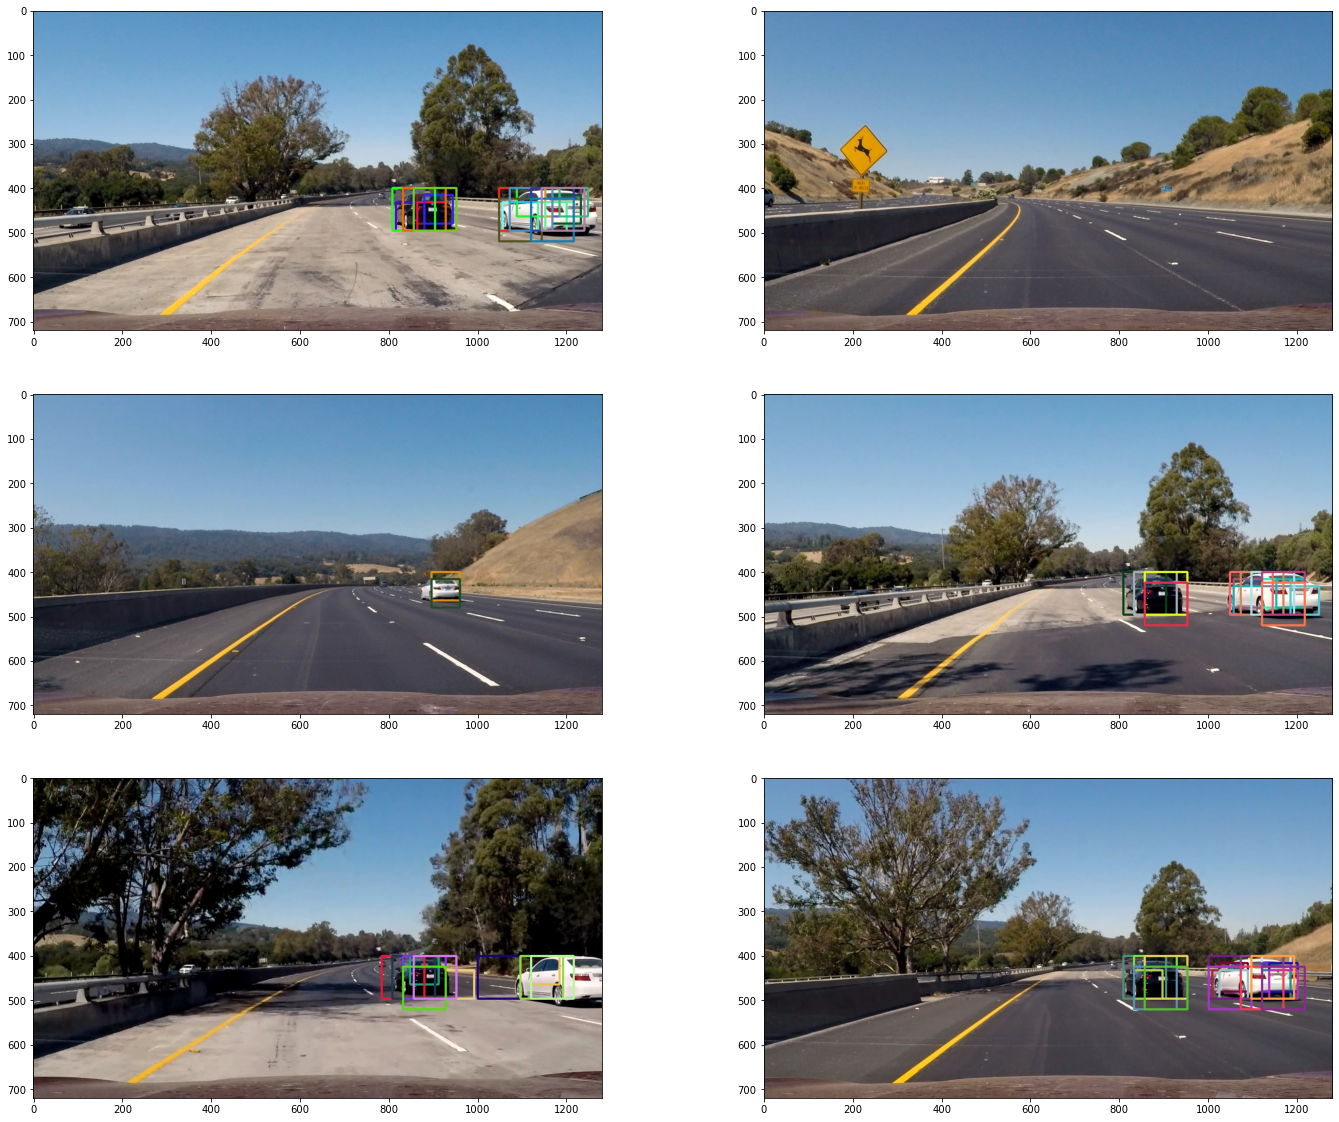

In [43]:
visualize_images(result_img_all_boxes, 2, "Result of all detected boxes")

# Visualize areas with most detections

Heatmap


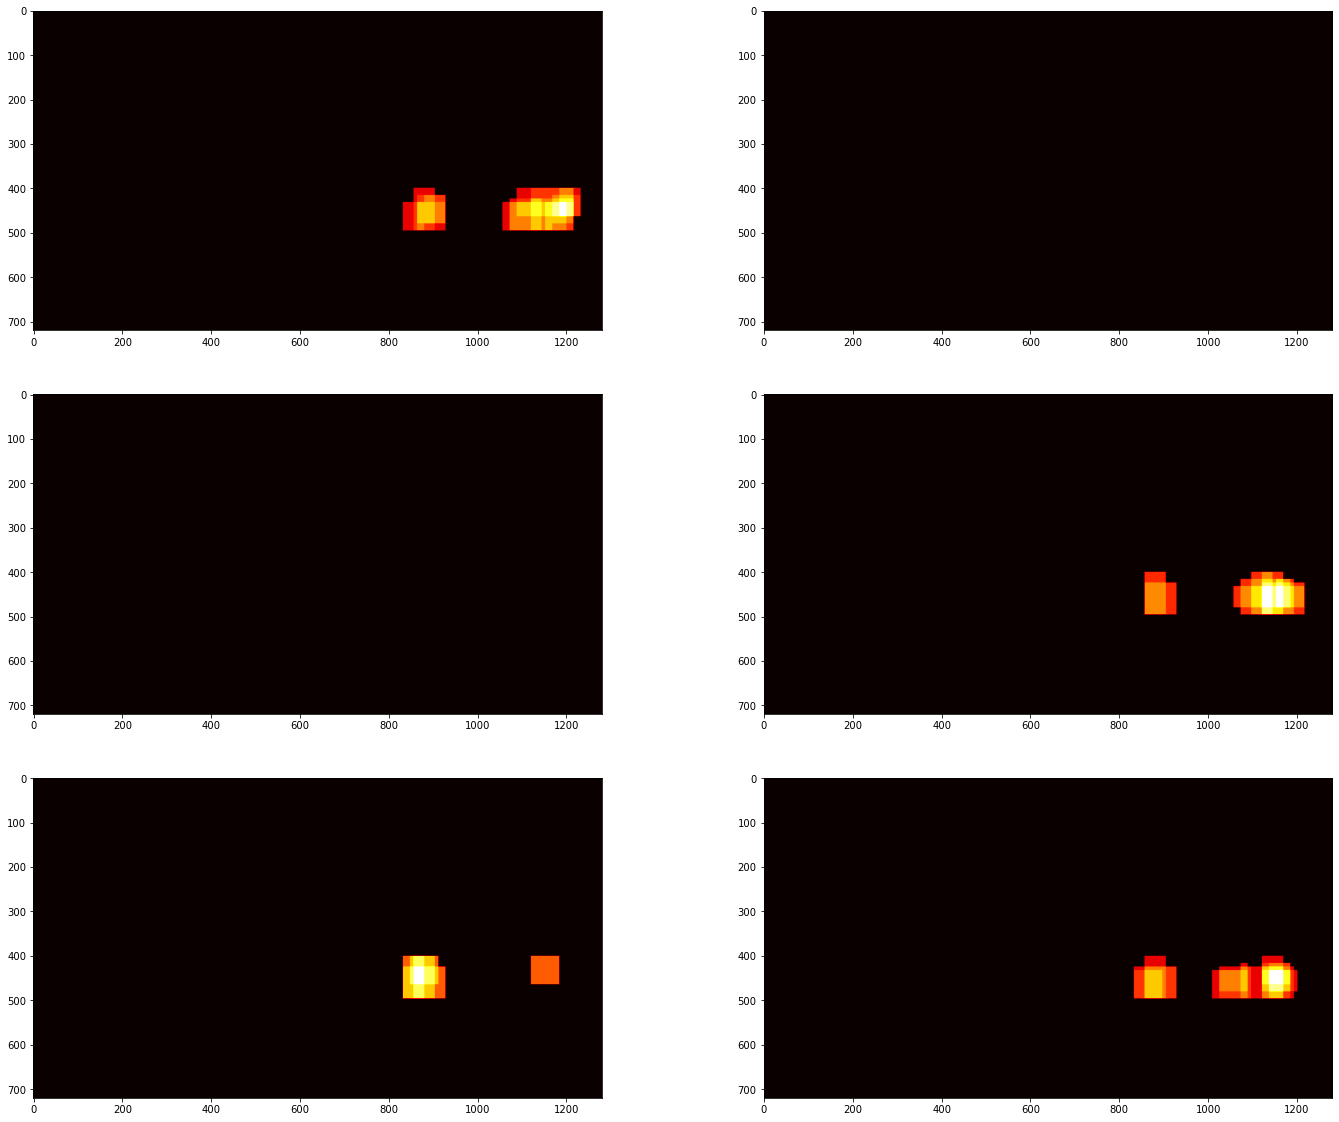

In [44]:
 
visualize_images(heatmap_images, 2, "Heatmap", cmap="hot")

# Visualize labeled images 

Labeled images


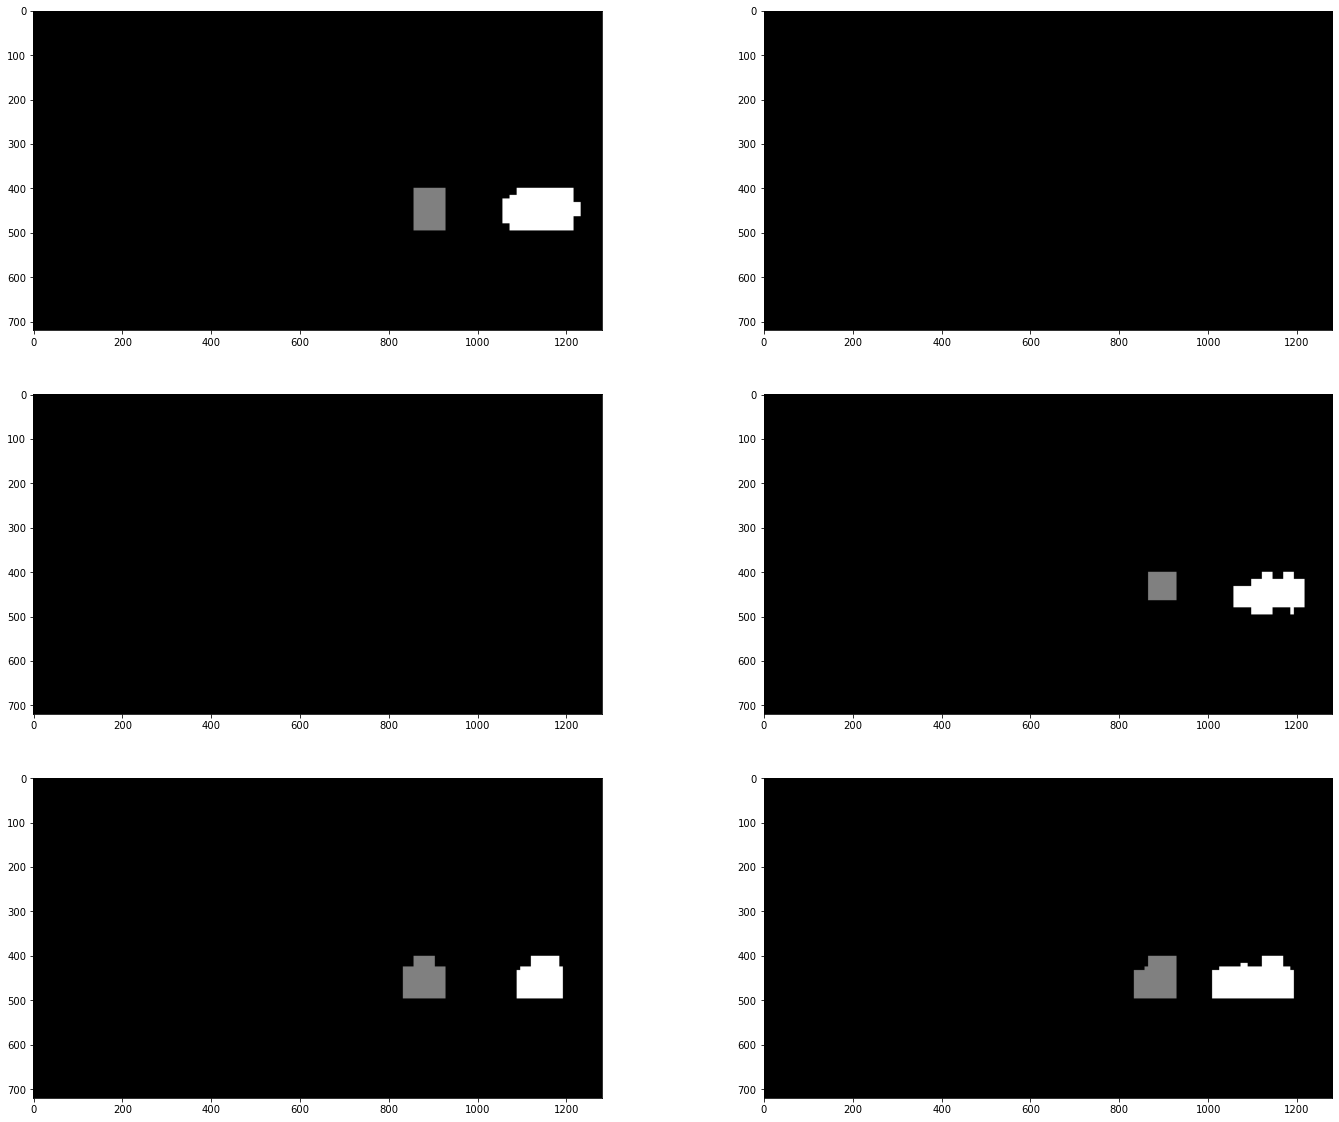

In [ ]:
visualize_images(label_images, 2, "Labeled images", cmap="gray")

# Visualize final images

Final images


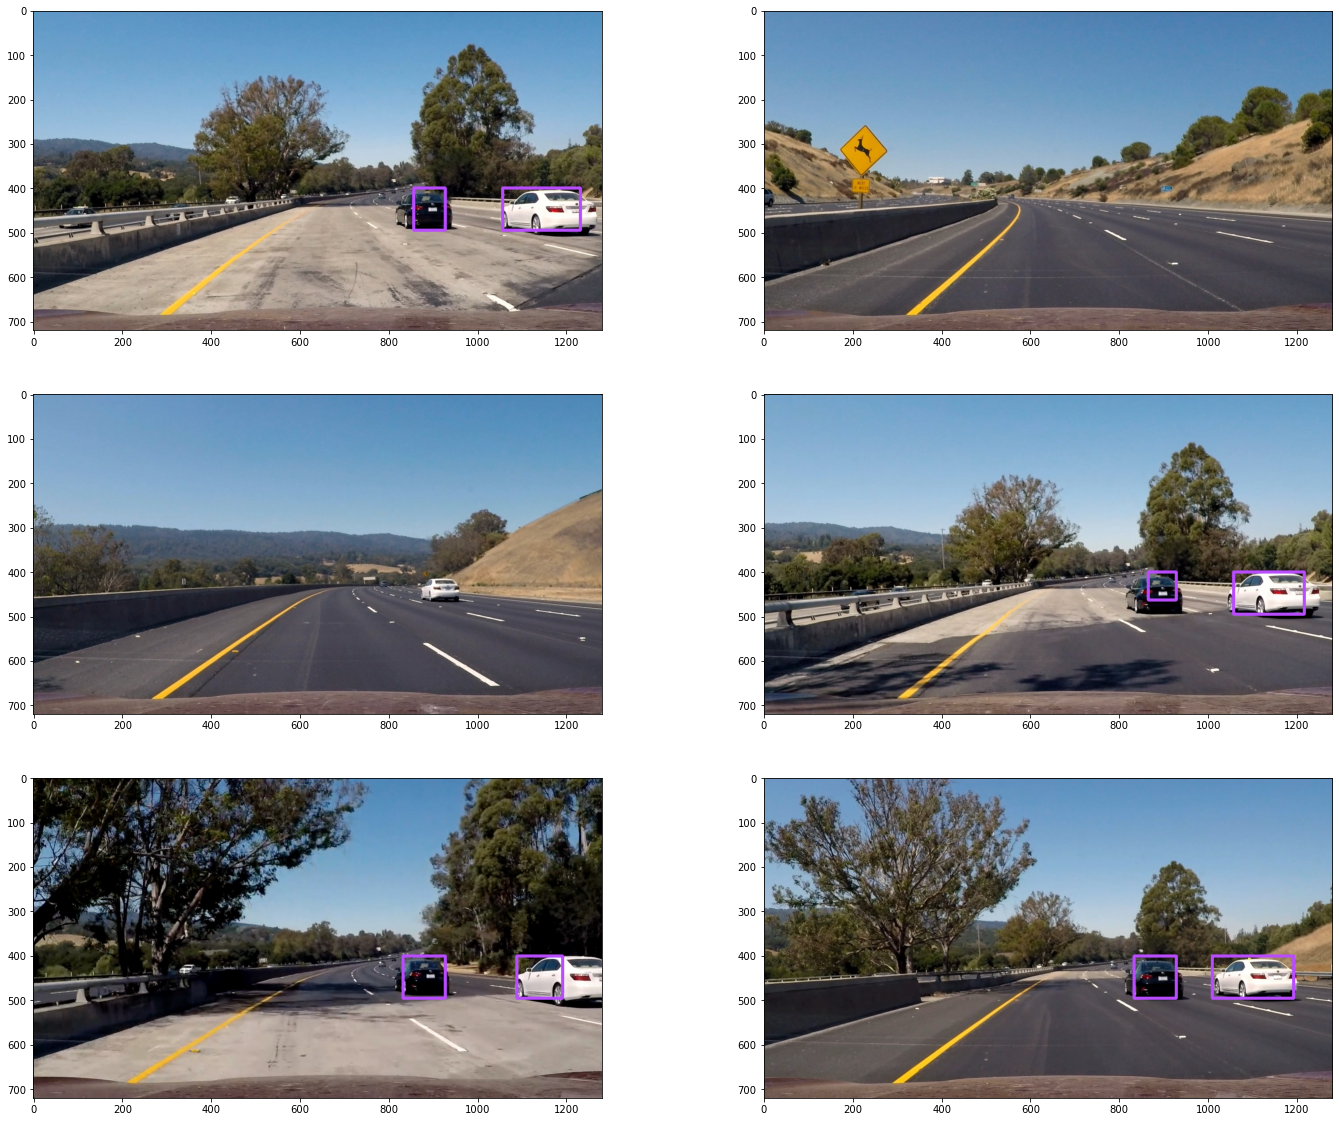

In [ ]:
visualize_images(result_images, 2, "Final images")


# Processing video

In [322]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import queue


class DetectionInfo():
    def __init__(self):
        self.max_size = 10
        self.old_bboxes = queue.Queue(self.max_size)
        self.heatmap = np.zeros_like(test_images[0][:, :, 0])

    def get_heatmap(self):
        self.heatmap = np.zeros_like(test_images[0][:, :, 0])
        if self.old_bboxes.qsize() == self.max_size:
            for bboxes in list(self.old_bboxes.queue):
                self.heatmap = add_heat(self.heatmap, bboxes)
                #self.heatmap = apply_threshold(self.heatmap, 2)
            self.heatmap = apply_threshold(self.heatmap, 20)
        return self.heatmap

    def get_labels(self):
        return label(self.get_heatmap())

    def add_bboxes(self, bboxes):
        if len(bboxes) < 1:
            return
        if self.old_bboxes.qsize() == self.max_size:
            self.old_bboxes.get()
        self.old_bboxes.put(bboxes)


In [323]:
def find_vehicles(image):
    bboxes = get_rectangles(image)
    detection_info.add_bboxes(bboxes)
    labels = detection_info.get_labels()
    if len(labels) == 0:
        result_image = image
    else:
        bboxes, result_image,label_image = draw_labeled_bboxes(image, labels)

    return result_image


In [331]:
def debugging(test_image):

    rectangles = get_rectangles(test_image)
    result_img_all_boxes=draw_boxes(test_image, rectangles, color='random', thick=3)
    heatmap_image = np.zeros_like(test_image[:, :, 0]) #make a copy of the test image with all values =0
    heatmap_image = add_heat(heatmap_image, rectangles)
    heatmap_image = apply_threshold(heatmap_image, 2)
    labels = label(heatmap_image)
    rectangles, result_image,label_image = draw_labeled_bboxes(test_image, labels)

    scale_image= visualize_bboxes(test_image)

    merged=concat_tile_resize([[result_image],[scale_image,result_img_all_boxes]]) #return final_out_img with other pictures underneath
    return merged
    

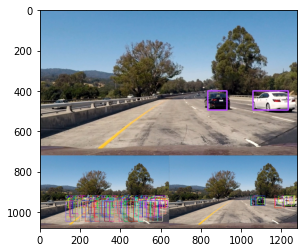

In [333]:
merged_pic=debugging(test_images[0])
plt.imshow(merged_pic)

In [332]:
detection_info = DetectionInfo()
detection_info.old_heatmap = np.zeros_like(test_images[0][:, :, 0])
Output_video = './output.mp4'
Input_video = './project_video.mp4'
debug=True
clip1 = VideoFileClip(Input_video)
# This function send frame image & expects color images as a return
if(debug):
    video_clip = clip1.fl_image(debugging)
    video_clip.write_videofile(Output_video, audio=False)
else:
    video_clip = clip1.fl_image(find_vehicles)
    video_clip.write_videofile(Output_video, audio=False)


Moviepy - Building video ./output.mp4.
Moviepy - Writing video ./output.mp4



t:   1%|          | 12/1260 [01:55<3:41:09, 10.63s/it, now=None]

KeyboardInterrupt: 